[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neo4j-field/call-transcripts-automation/blob/main/students/2_PostIngestionProcessing.ipynb)



# Recap - Ingest Transcripts

Here's a snippet of the transcripts that were ingested in the previous notebook and the resulting schema.

In [12]:
from IPython.display import display, JSON
import requests

file_uri = "https://storage.googleapis.com/neo4j-se-jeff-davis/callcenter/transcripts.json"

data = requests.get(file_uri).json()

display(JSON(data[:2]))

<IPython.core.display.JSON object>

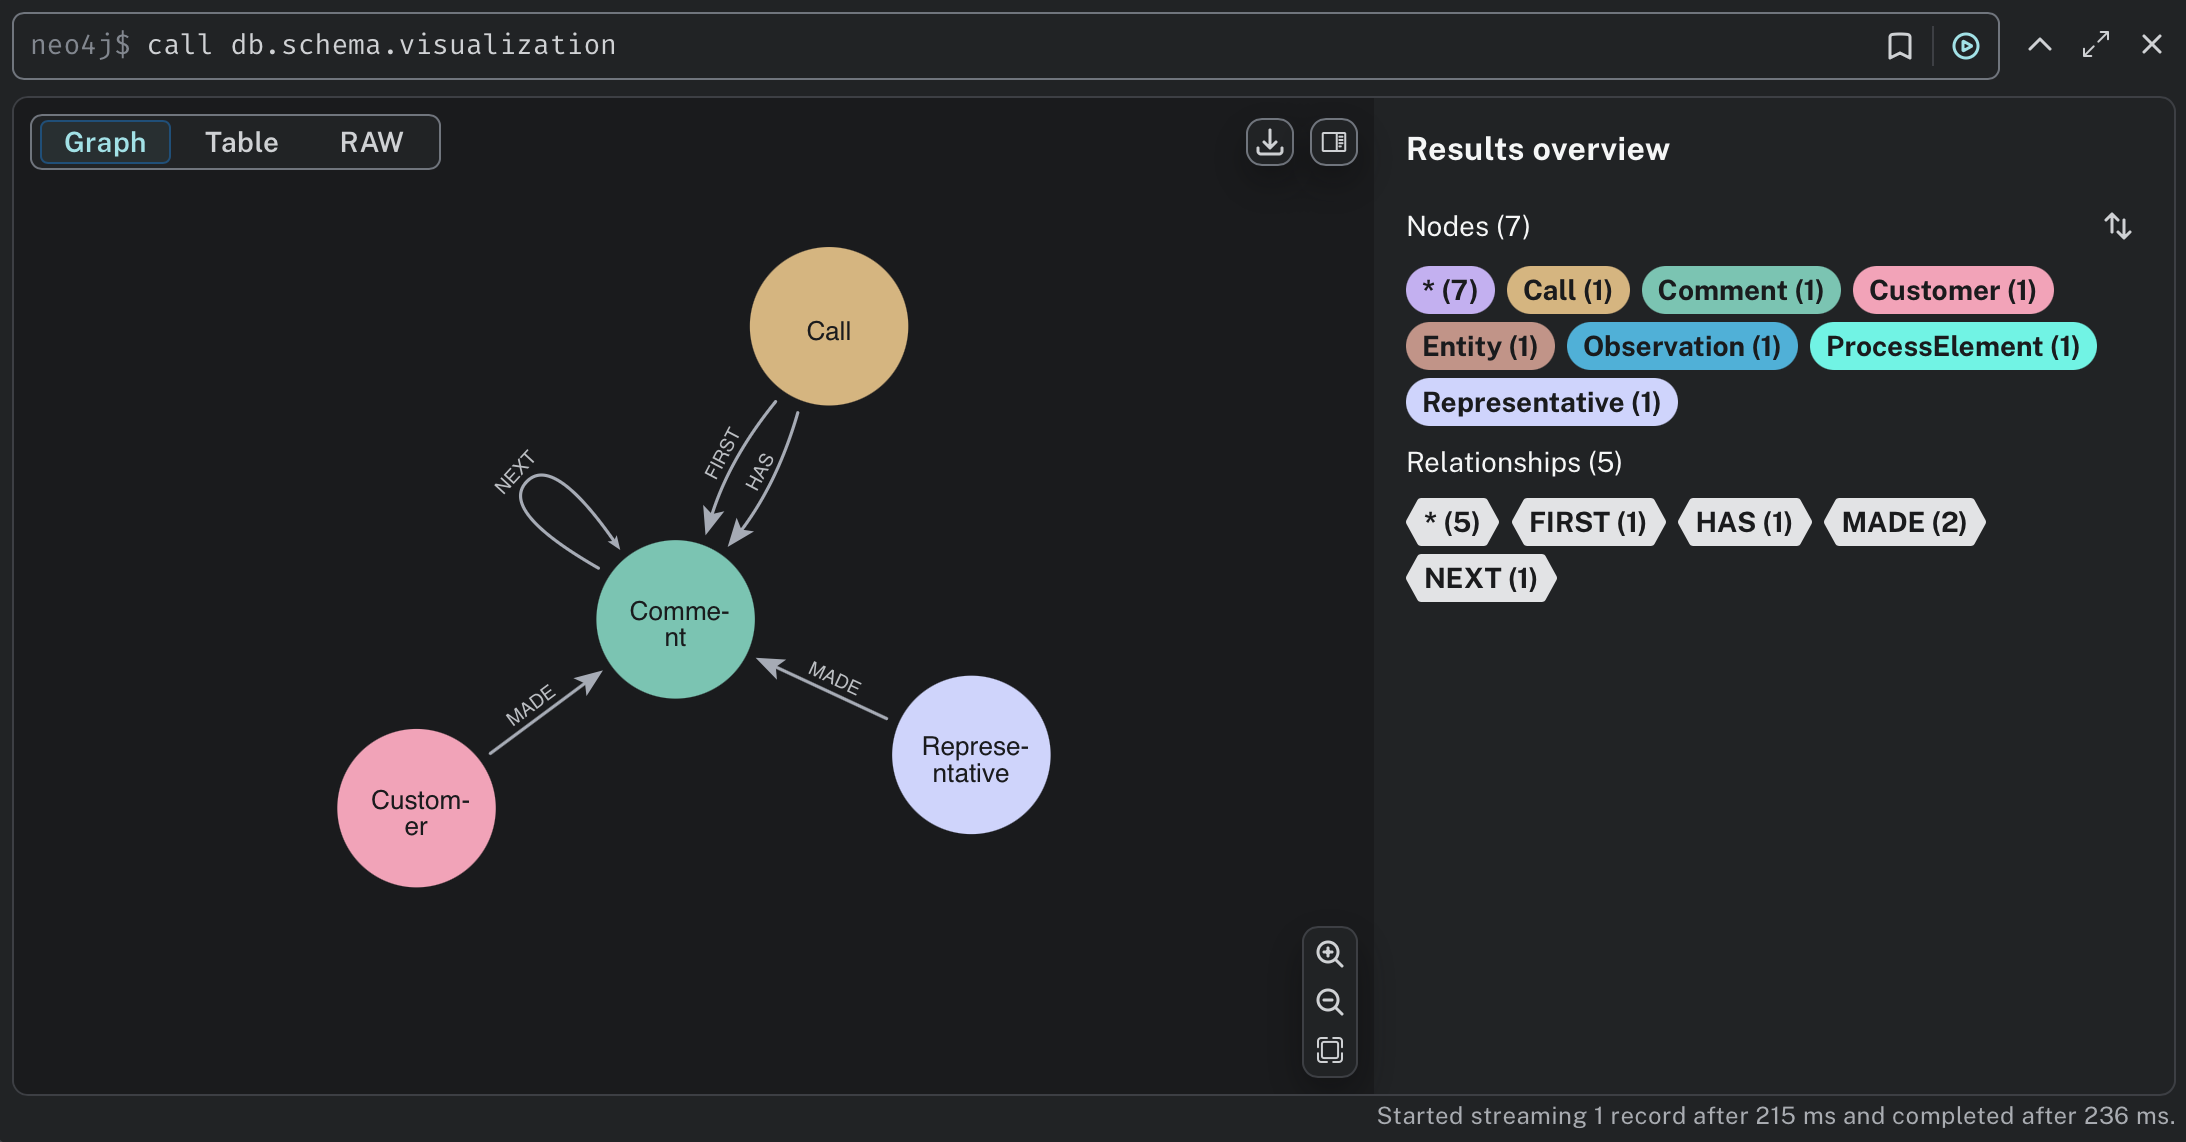

# Post Ingestion Processing Overview

This is a [Python](https://www.python.org/) project for constructing a business-process aware knowledge graph for customer service automation and acceleration.

This notebook takes the ingested transcripts and further enchances the data retrieved by ChatBot for greater clarity and accuracy.

Firstly, we ask the LLM to extract elements that represent the process executed during the call (Actions, Observations, States, Resolutions, etc) and store these entities into the Knowledge Graph, including transitions between actions during calls.

Then we configure the agent to execute GDS algorithms and write the results back to the graph. This process encompasses the following tasks:

- Create a GDS session
- Create a GDS projection
- Execute Centrality Algorithm (pageRank)
- Execute Community Detection (WCC)
- Store the Communities in Neo4j
- Close the GDS session

We then have the agent take relationships between the observations and "lift up" to the process element.

Lastly, we infer names for Processes by consulting with an LLM to group Processes and Actions by community id.

**Update Student's environment code (received via email)**

In [14]:
# The student's environment file (aura.env) will be downloaded into the notebook's
# files after executing the 'Setup' section.
STUDENT_ENV_CODE="6476"

# Setup

In [15]:
%%capture
!pip --quiet install python-dotenv neo4j graphdatascience
!pip --quiet install neo4j-viz pyvis yfiles_jupyter_graphs_for_neo4j
!pip --quiet install langchain_neo4j langchain_openai langgraph
# parallel

In [16]:
import pandas as pd
import os

## Dotenv configuration

In [24]:
# Download env file from S3
import requests

# GCS URL
GCS_FILE_URL = "https://storage.googleapis.com/neo4j-nodes-network-2025/students/"+STUDENT_ENV_CODE+"/aura.txt"

# Local filename to save
LOCAL_ENV_FILE = "aura.env"

# Fetch the file and write it locally
response = requests.get(GCS_FILE_URL)
if response.status_code == 200:
    with open(LOCAL_ENV_FILE, "wb") as f:
        f.write(response.content)
    print(f"✅ Environment file downloaded and saved as {LOCAL_ENV_FILE}")
else:
    raise Exception(f"❌ Failed to fetch the .env file: {response.status_code}")

✅ Environment file downloaded and saved as aura.env


In [ ]:
# NOTE: Upload files (.env)!!!!
# You can skip this cell if not using a ws.env file - alternative to above
from dotenv import load_dotenv
import os

if os.path.exists(LOCAL_ENV_FILE):
     load_dotenv(LOCAL_ENV_FILE, override=True)

     # Neo4j
     NEO4J_URI = os.getenv('NEO4J_URI')
     NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
     NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')

     AURA_API_CLIENT_ID=os.getenv('AURA_API_CLIENT_ID')
     AURA_API_CLIENT_SECRET=os.getenv('AURA_API_CLIENT_SECRET')
     AURA_API_TENANT_ID=os.getenv('AURA_API_TENANT_ID')
     AURA_INSTANCEID=os.getenv('AURA_INSTANCEID')

     IS_AURA = os.environ.get("AURA", True) is True

     # AI
     LLM = 'gpt-4o'
     AZURE_OPENAI_API_KEY = os.getenv('AZURE_OPENAI_API_KEY')

print(f"OPENAI_KEY: {AZURE_OPENAI_API_KEY}")
print(f"AURA_API_TENANT_ID: {AURA_API_TENANT_ID}")

## Connecting to Neo4j

Provide your Neo4j credentials. We need the DB conection URL, the username (probably neo4j), and your password.

If using an env file under the notebook's files folder, reference the:
- URI
- username
- password

Log into your Neo4j instance using https://browser.neo4j.io/.

In [19]:
from neo4j import GraphDatabase

# You can skip this cell if not using a ws.env file - alternative to above
# Get credentials from .env file
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')

kg = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

## Test connectivity

In [ ]:
# total node counts
res = kg.execute_query('''
    CALL apoc.meta.stats()
    YIELD labels
    UNWIND keys(labels) AS nodeLabel
    RETURN nodeLabel, labels[nodeLabel] AS nodeCount
    ORDER BY nodeCount DESC
''')

df = pd.DataFrame([{'nodeLabel': d['nodeLabel'],
               'nodeCount':d['nodeCount']} for d in res.records])
df[:]

# Inspect the current schema and data

In [21]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from yfiles_jupyter_graphs_for_neo4j import Neo4jGraphWidget
g = Neo4jGraphWidget(kg)
g.show_cypher(
"""
match(c:Call)
optional match(c)-[r1:HAS]-(cmt:Comment)-[r2:MADE]-(p:Customer|Representative)
return c,r1,cmt,r2,p limit 250
""", "organic"
)

In [ ]:
g.show_cypher(
"""
MATCH p=(n:Call {id: "C001"})-[:FIRST]->(c1:Comment)-[:NEXT*]->(c2:Comment)
return p""", "organic"
)

# Variables and Utility functions

## Parallel Execution (MAX_PROCESSES)

In [ ]:
# from parallel import MAX_PROCESSES
MAX_PROCESSES = 5

In [ ]:
EXPECTED_SESSIONS_NODE_COUNT = 10000
EXPECTED_SESSIONS_RELATIONSHIP_COUNT = 100000

In [ ]:
from langchain_openai import OpenAIEmbeddings, AzureOpenAIEmbeddings

DEFAULT_EMBEDDING_MODEL = "text-embedding-3-small"
COMMENT_VECTOR_INDEX_NAME = "commentEmbeddings"
ENTITY_VECTOR_INDEX_NAME = "entityEmbeddings"
OBSERVATION_EMBEDDING_INDEX_NAME = "observationEmbeddings"
PROCESS_ELEMENT_EMBEDDING_INDEX_NAME = "processElementEmbeddings"
VECTOR_INDEX_DIM = 128
VECTOR_EQUIVALENCE_THRESHOLD = 0.9
DEFAULT_k = 7

# embedder = OpenAIEmbeddings(model=DEFAULT_EMBEDDING_MODEL, dimensions=VECTOR_INDEX_DIM)

embedder = AzureOpenAIEmbeddings(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    model=DEFAULT_EMBEDDING_MODEL,
    openai_api_version="2025-01-01-preview",
    dimensions=VECTOR_INDEX_DIM
)

In [ ]:
from pydantic import BaseModel, Field
from typing import List

class Entity(BaseModel):
    name: str = Field(None, title="The name of the entity")
    description: str = Field(None, title="A 1-2 sentence description of the entity")
    quote: str = Field(None, title="An exactly-copied quote snippet from the chunk that mentions the entity")

class EntityArray(BaseModel):
    entities: List[Entity] = Field(None, title="An array of extracted entities")

class StateObservation(BaseModel):
    state: str = Field(None, title="A description of the current state of the conversation")

class ActionSelection(BaseModel):
    action: str = Field(None, title="A description of the action taken based on the most recent comment")

class DecisionInference(BaseModel):
    decision: str = Field(None, title="A description of the decision made based on the most recent comment")

class ResolutionInference(BaseModel):
    resolution: str = Field(None, title="A description of the resolution made based on the call")

class GroupDescription(BaseModel):
    name: str = Field(None, title="The name of the group")
    description: str = Field(None, title="A 1-paragraph description of the group's characteristic ideas")

In [ ]:
from langchain_openai import AzureChatOpenAI, ChatOpenAI
# from structured_outputs import EntityArray, StateObservation, ActionSelection, GroupDescription, ResolutionInference

# LLM enums
FAST_CHAT = "gpt-4o-mini"
CHAT = "gpt-4o"

entity_extractor_llm = AzureChatOpenAI(azure_deployment=FAST_CHAT, api_version="2025-01-01-preview", temperature=0).with_structured_output(EntityArray)
group_description_llm = AzureChatOpenAI(azure_deployment=FAST_CHAT, api_version="2025-01-01-preview", temperature=0).with_structured_output(GroupDescription)

state_observation_llm = AzureChatOpenAI(azure_deployment=FAST_CHAT, api_version="2025-01-01-preview", temperature=0.5).with_structured_output(StateObservation)
action_selection_llm = AzureChatOpenAI(azure_deployment=FAST_CHAT, api_version="2025-01-01-preview", temperature=0.5).with_structured_output(ActionSelection)
resolution_inference_llm = AzureChatOpenAI(azure_deployment=FAST_CHAT, api_version="2025-01-01-preview", temperature=0.5).with_structured_output(ResolutionInference)

## Create Graph and Vector embeddings stores

### Create Neo4j DB connection

In [ ]:
from langchain_neo4j import Neo4jGraph

def create_graph_store():
    graph_db = Neo4jGraph(url=os.getenv("NEO4J_URI"), username=os.getenv("NEO4J_USERNAME"), password=os.getenv("NEO4J_PASSWORD"))
    graph_db.query("CREATE CONSTRAINT commentId IF NOT EXISTS FOR (c:Comment) REQUIRE c.id IS NODE KEY")
    graph_db.query("CREATE CONSTRAINT callId IF NOT EXISTS FOR (c:Call) REQUIRE c.id IS NODE KEY")
    graph_db.query("CREATE CONSTRAINT entityName IF NOT EXISTS FOR (e:Entity) REQUIRE e.name IS NODE KEY")
    graph_db.query("CREATE CONSTRAINT customerId IF NOT EXISTS FOR (c:Customer) REQUIRE c.id IS NODE KEY")
    graph_db.query("CREATE CONSTRAINT representativeId IF NOT EXISTS FOR (r:Representative) REQUIRE r.id IS NODE KEY")
    graph_db.query("CREATE CONSTRAINT observationId IF NOT EXISTS FOR (o:Observation) REQUIRE o.id IS NODE KEY")
    graph_db.query("CREATE CONSTRAINT processElementId IF NOT EXISTS FOR (p:ProcessElement) REQUIRE p.id IS NODE KEY")
    return graph_db

### Create Vector Stores

In [ ]:
from langchain_neo4j import Neo4jVector

# We're using multiple vector indexes because we want to query for chunks and entities separately
def create_vector_stores():
    comment_vector_db = Neo4jVector(
        embedder,
        url=os.getenv("NEO4J_URI"),
        username=os.getenv("NEO4J_USERNAME"),
        password=os.getenv("NEO4J_PASSWORD"),
        index_name=COMMENT_VECTOR_INDEX_NAME,
        embedding_dimension=VECTOR_INDEX_DIM,
        node_label="Comment"
    )
    comment_vector_db.create_new_index()
    entity_vector_db = Neo4jVector(
        embedder,
        url=os.getenv("NEO4J_URI"),
        username=os.getenv("NEO4J_USERNAME"),
        password=os.getenv("NEO4J_PASSWORD"),
        index_name=ENTITY_VECTOR_INDEX_NAME,
        embedding_dimension=VECTOR_INDEX_DIM,
        node_label="Entity"
    )
    entity_vector_db.create_new_index()
    observation_vector_db = Neo4jVector(
        embedder,
        url=os.getenv("NEO4J_URI"),
        username=os.getenv("NEO4J_USERNAME"),
        password=os.getenv("NEO4J_PASSWORD"),
        index_name=OBSERVATION_EMBEDDING_INDEX_NAME,
        embedding_dimension=VECTOR_INDEX_DIM,
        node_label="Observation"
    )
    observation_vector_db.create_new_index()
    process_element_vector_db = Neo4jVector(
        embedder,
        url=os.getenv("NEO4J_URI"),
        username=os.getenv("NEO4J_USERNAME"),
        password=os.getenv("NEO4J_PASSWORD"),
        index_name=PROCESS_ELEMENT_EMBEDDING_INDEX_NAME,
        embedding_dimension=VECTOR_INDEX_DIM,
        node_label="ProcessElement"
    )
    process_element_vector_db.create_new_index()
    return comment_vector_db, entity_vector_db, observation_vector_db, process_element_vector_db

## Prompts

In [ ]:
POLICIES = [
    "We must have the customer's account number before attempting to resolve their issue."
]
state_observation_prompt = (
    "Please read the conversation and determine the current state of the interaction as of the most recent comment in 1-2 sentences.\n"
    "This should include the problem being solved, the current topic of discussion, and the sentiment of the customer.\n"
    "Do not mention 'this' conversation, or 'this' customer or representative, but rather describe the situation in abstract terms (i.e., 'the' customer, 'the' account', etc.).\n"
    "Please do not mention next steps - this is a snapshot of the current state only.\n\n"
    "When evaluating the state, please consider the following policies and distinguish states based on whether they are satisfied, in addition to general characteristics as described above:\n"
    + "\n".join(POLICIES) +
    "\n\nThe output should be a JSON object with the following format:\n\n"
    '{\n    "state": "Description of the current state of the conversation"\n}'
)

action_selection_prompt = """
Please read the conversation and determine what action was taken based on the most recent comment.
The action is inferred from the most recent comment and the context of the conversation.
The action should be described in 1 sentence, 2 max if necessary.
Do not say who took the action, but rather say abstractly what the action was.  Respond as if you are figuring out what the employee was told to do before the most recent comment.
For instance, instead of saying, "The employee asked the customer for their account number," you would say, "Ask for the customer's account number."
Also do not ascribe any reasoning or motivation to the action, just describe the action itself.
The output should be a JSON object with the following format:

{
    "action": "Description of the action taken"
}
"""

decision_inference_prompt = """
Please read the conversation and infer what decision was made based on the most recent comment.
The most recent comment represents the decision that was made, so you should infer what the decision was based on the context of the conversation and the transition from the previous comments to the most recent one.
Look at the conversation leading up to the most recent comment, then look at the most recent comment itself, and infer what the critical factors were in the thought process.
The decision should be described in a few sentences, no more than 1 paragraph.
Don't say who made the decision, but describe the likely chain of thought involved in making the decision.
When you have determined the decision made, provide a very brief (less than or equal to 1 phrase) name for it.
The output should be a JSON object with the following format:

{
    "decision": "Description of the decision made"
}
"""

resolution_inference_prompt = """
In 1-2 sentences, please describe the resolution of the call with the transcript provided.
The resolution should describe the final state of the call, the outcome, the customer sentiment, and the favorability of the outcome to the service provider.
The favorability is determined by whether the customer retains their services or increases their spend, as well as how much time or expense the service provider incurred in resolving it.
Provide the output in the following format:

{
    "resolution": "Description of the resolution"
}
"""

def group_description_prompt(mode):
    # Store example responses as separate variables
    example_action = """Content:
"Request the customer's account number to check the status."
"Request the customer's account number to check the service status."
"Request the customer's account number to check their connection status."
"Request the customer's account number to check their service."
"Request the customer's account number to check their current plan."
"Request the customer's account number to check their current plan."
"Request the customer's account number to review the bill."
"Request the customer's account number to review the charges."
"Request the customer's account number to review the bills."

Answer:
{
    "name": "Request Account Number",
    "description": "Ask the customer for their account number."
}
"""

    example_general = """Content:
"The customer is experiencing internet connectivity issues that occur specifically during rain, which has been linked to potential corrosion caused by bird droppings on the external wiring. The sentiment is positive as the customer is receptive to the employee's suggestion to clean the affected areas."
"The customer is experiencing ongoing intermittent internet outages that are impacting their business, expressing frustration over the situation. The employee is actively troubleshooting by checking for external interference and has already attempted several solutions, including restarting the router and updating firmware. The conversation reflects a sense of urgency and concern from the customer."
"The customer is experiencing ongoing issues with slow internet speed despite having already restarted their router multiple times. The sentiment is one of frustration as the customer seeks further assistance after initial troubleshooting steps were ineffective."
"The customer is experiencing unreliable internet connectivity, which has been an issue for the past week. The employee is currently gathering information to troubleshoot the problem, and the customer has provided details about the location of their modem and router."
"The customer is experiencing intermittent internet connectivity issues that correlate with rainy weather. The employee is actively troubleshooting the problem by asking for the customer's account details and conducting basic checks regarding the router's location. The sentiment is cooperative, with both parties engaged in problem-solving."
"The customer is experiencing ongoing issues with their internet connection, which has been unreliable for a week despite multiple attempts to reboot the modem and router. The sentiment is one of frustration as the customer seeks a resolution to the recurring problem."
"The customer is experiencing an internet connectivity issue that occurs specifically during rain, while other electronic devices function normally. The employee is actively troubleshooting the problem by asking questions about the router's location and other devices."

Answer:
{
    "name": "Intermittent and Weather-Related Internet Connectivity Issues",
    "description": "Customers are experiencing internet connectivity issues, often intermittent or weather-related, leading to frustration and a need for troubleshooting. Employees are actively working to diagnose the problems by gathering information, checking external factors, and suggesting solutions, with varying levels of cooperation from customers."
}
"""

    # Select the appropriate example based on mode
    example_content = example_action if mode == "Action" else example_general

    # Build the final string using concatenation (not an f-string)
    return (
        "You are an AI designed to distill text passages based on their thematic similarities. "
        "Your task is to process a set of text strings and generate generate safe and harmless responses with the following outputs:\n\n"
        "Description " + ("(1 sentence)" if mode == "Action" else "(2 sentences max)") + ": " +
        ("The core action that distills the essential meaning of the list of actions."
         if mode == "Action"
         else "Clearly describe the shared themes without referring to the existence of a collection or the act of summarization. Focus on the core issues, sentiments, and actions.") + "\n"
        "Name (less than 1 sentence): Provide a concise, descriptive label that captures the common theme.\n"
        "Avoid phrases like 'the content,' 'the text,' or 'the collection'—instead, directly present the themes and insights.\n\n"
        "For example, given the following content, here is an example of a description and name:\n\n"
        + example_content + "\n\n"
        "Note also that the lines of content are ranked with importance scores, so please weight these appropriately in your analysis.\n"
        "The output should be a JSON object with the following format:\n\n"
        "{\n"
        '    "name": "Generated name",\n'
        '    "description": ' + ('"The distilled action statement"' if mode == "Action" else '"Description of the main ideas or themes"') + '\n'
        "}"
    )

## Utility Functions

In [ ]:
from datetime import timedelta
from graphdatascience import GraphDataScience
from graphdatascience.session import AuraAPICredentials, GdsSessions, DbmsConnectionInfo, AlgorithmCategory

### Read Nodes (Get Calls, Process Observations)
At several points in the code we read nodes from the graph. This function abstracts the process of reading nodes and can handle different labels.

In [ ]:
def read_nodes(graph_db, label="Call", return_label=False):
    if label == "Call":
        nodes = graph_db.query("""
            MATCH (c:Call)
            MATCH (c)-[:FIRST]->(:Comment)-[:NEXT]->*(comm:Comment)<-[:MADE]-(u)
            WITH c, collect({
                id: comm.id,
                content: comm.content,
                customer: u:Customer
            }) AS comments
            RETURN c.id AS id, comments
        """)
    else:
        nodes = graph_db.query(f"""
            MATCH (n:{label})
            RETURN
                n.id AS id,
                {"[lbl IN labels(n) WHERE NOT lbl IN ['Observation', 'ProcessElement']][0] AS label," if return_label else ""}
                coalesce(n.description, n.content) AS description
        """)
    return nodes

### Extract Elements of the Process

In [ ]:
def extract_process_elements(call):
    state_observations = []
    action_selections = []
    # inferred_decisions = []
    inferred_resolutions = []
    for i, comment in enumerate(call["comments"]):
        # The "subcall" at position i is the list of comments up to and including the comment at position i
        # We don't need this list itself, we'll just put it into a transcript string for the LLM
        subcall_transcript = (
            "CALL TRANSCRIPT:\n"
            + "\n".join(
                [f'{"Customer" if comm["customer"] else "Employee"}: {comm["content"]}'
                for comm in call["comments"][:i]]
            )
            + f"\n\nLATEST COMMENT:\n{'Customer' if comment['customer'] else 'Employee'}: {comment['content']}"
        )
        # for each comment in the call such that comment.customer is True, we need to
        #   get all the comments up to and including that comment in a list, and then
        #   feed that list into the state observation LLM
        if comment["customer"]:
            extracted_state = state_observation_llm.invoke([
                ("system", state_observation_prompt),
                ("human", subcall_transcript)
            ])
            state_observations.append({
                "comment_id": comment["id"],
                "description": extracted_state.state
            })
        # for each comment in the call such that comment.customer is False, we need to
        #   get all the comments up to and including that comment in a list, and then
        #   feed that list into the action selection LLM
        else:
            extracted_action = action_selection_llm.invoke([
                ("system", action_selection_prompt),
                ("human", subcall_transcript)
            ])
            action_selections.append({
                "comment_id": comment["id"],
                "description": extracted_action.action
            })
            # fetch the resolution node for the call
            if i == len(call["comments"]) - 1:
                extracted_resolution = resolution_inference_llm.invoke([
                    ("system", resolution_inference_prompt),
                    ("human", subcall_transcript)
                ])
                inferred_resolutions.append({
                    "call_id": call["id"],
                    "last_comment_id": comment["id"],
                    "description": extracted_resolution.resolution
                })
    return state_observations, action_selections, inferred_resolutions

### Write Process Observations

In [ ]:
def write_process_observations(calls, graph_db):
    for call in calls:
        # state_observations, action_selections, inferred_decisions = extract_process_elements(call)
        state_observations, action_selections, inferred_resolutions = extract_process_elements(call)
        # Create observations
        graph_db.query("""
            UNWIND $states AS state
            MATCH (comm:Comment {id: state.comment_id})
            CREATE (so:Observation {id: randomUUID()})
            MERGE (comm)-[:OBSERVED_STATE]->(so)
            SET so:State, so.description = state.description
        """, {
            "states": state_observations
        })
        # Create actions
        graph_db.query("""
            UNWIND $actions AS action
            MATCH (comm:Comment {id: action.comment_id})
            CREATE (ao:Observation {id: randomUUID()})
            MERGE (comm)-[:OBSERVED_ACTION]->(ao)
            SET ao:Action, ao.description = action.description
        """, {
            "actions": action_selections
        })
        # Create resolutions
        graph_db.query("""
            UNWIND $resolutions AS resolution
            MATCH (c:Call {id: resolution.call_id})
            CREATE (ro:Observation {id: randomUUID()})
            MERGE (c)-[:OBSERVED_RESOLUTION]->(ro)
            SET ro:Resolution, ro.description = resolution.description
        """, {
            "resolutions": inferred_resolutions
        })

### Create vector embeddings
Embed nodes of a given label

Comment nodes embed the `content` property, while other nodes embed the `description` property

In [ ]:
def embed_nodes(nodes, graph_db, label="Comment"):
    embeddings = embedder.embed_documents([node["content"] if "content" in node else node["description"] for node in nodes])
    print("Storing embeddings...")
    graph_db.query(f"""
        WITH $nodes AS nodes
        UNWIND nodes AS node
        MATCH (n:{label} {{id: node.id}})
        WITH n, node
        CALL db.create.setNodeVectorProperty(n, "embedding", node.embedding)
    """, {"nodes": [{**node, "embedding": embedding} for node, embedding in zip(nodes, embeddings)]})

### Write Transition Relationships
Merging the TRANSITION, ACTION_SELECTION, and PROCESS_END relationships between low-level observations

We will use these relationships for linking process elements (i.e., communities) later (see `write_lifted_rels`)

In [ ]:
def write_transition_rels(graph_db):
    graph_db.query("""
        MATCH (so:Observation)<-[:OBSERVED_STATE]-(c0:Comment)-[:NEXT]->(c1:Comment)-[:OBSERVED_ACTION]->(ao:Observation)
        CALL {
            WITH so, ao
            MERGE (so)-[:OBSERVED_ACTION_SELECTION]->(ao)
        } IN TRANSACTIONS OF 1000 ROWS
    """)
    graph_db.query("""
        MATCH (ao:Observation)<-[:OBSERVED_ACTION]-(c0:Comment)-[:NEXT]->(c1:Comment)-[:OBSERVED_STATE]->(so:Observation)
        CALL {
            WITH so, ao
            MERGE (ao)-[:OBSERVED_TRANSITION]->(so)
        } IN TRANSACTIONS OF 1000 ROWS
    """)
    graph_db.query("""
        MATCH (ro:Resolution)<-[:OBSERVED_RESOLUTION]-(c:Call)-[:FIRST]->()-[:NEXT]->*(last)
        WHERE NOT EXISTS {
            (last)-[:NEXT]->()
        }
        MATCH (last)-->(obs:Observation)
        CALL {
            WITH ro, obs
            MERGE (obs)-[:OBSERVED_PROCESS_END]->(ro)
        } IN TRANSACTIONS OF 1000 ROWS
    """)

### Create GDS Session

In [ ]:
def create_graph_data_science_session(session_name):
    if IS_AURA:
        client_id = os.environ["AURA_API_CLIENT_ID"]
        client_secret = os.environ["AURA_API_CLIENT_SECRET"]
        # If your account is a member of several tenants, you must also specify the tenant ID to use
        tenant_id = os.environ["AURA_API_TENANT_ID"]
        sessions = GdsSessions(api_credentials=AuraAPICredentials(client_id, client_secret, project_id=tenant_id))
        # Estimate the memory needed for the GDS session
        memory = sessions.estimate(
            node_count=EXPECTED_SESSIONS_NODE_COUNT,
            relationship_count=EXPECTED_SESSIONS_RELATIONSHIP_COUNT,
            algorithm_categories=[AlgorithmCategory.CENTRALITY, AlgorithmCategory.COMMUNITY_DETECTION],
        )
        # Identify the AuraDB instance
        db_connection = DbmsConnectionInfo(
            uri=os.environ["NEO4J_URI"], username=os.environ["NEO4J_USERNAME"], password=os.environ["NEO4J_PASSWORD"]
        )
        # Create a GDS session!
        gds = sessions.get_or_create(
            # we give it a representative name
            session_name=session_name,
            memory=memory,
            db_connection=db_connection,
            ttl=timedelta(hours=5),
        )
        return gds
    else:
        gds = GraphDataScience(
            os.getenv("NEO4J_URI"),
            auth=(os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD")),
            database=NEO4J_DATABASE,
        )
        return gds

### Create GDS Projection
Nifty trick here where we project relationships into GDS that don't exist in the graph

Injecting a threshold parameter to allow us to easily adjust the similarity threshold during testing

In [ ]:
def project_process_observations_to_gds(gds, session_name):
    threshold = VECTOR_EQUIVALENCE_THRESHOLD
    query = f"""
    // CYPHER runtime=parallel  // Use parallel runtime in Aura Business Crtical or Virtual Dedicated Cloud for speed/scale
    MATCH (obs:Observation)
    OPTIONAL MATCH (similarObs:Observation)
    WHERE elementId(obs) <> elementId(similarObs)
    // Get all vectors within a certain cosine similarity threshold
    AND vector.similarity.cosine(obs.embedding, similarObs.embedding) > {threshold}
    AND ((obs:State AND similarObs:State)
    OR (obs:Action AND similarObs:Action)
    OR (obs:Resolution AND similarObs:Resolution))
    // These are not stored relationships, they're on-the-fly computed similarity relations
    // Nevertheless, we can project them into a GDS graph via Cypher projection
    WITH obs, similarObs, vector.similarity.cosine(obs.embedding, similarObs.embedding) AS score
    RETURN gds.graph.project{".remote" if IS_AURA else ""}({"" if IS_AURA else "$graph_name, "}obs, similarObs, {{
        sourceNodeProperties: {{}},
        targetNodeProperties: {{}},
        sourceNodeLabels: labels(obs),
        targetNodeLabels: labels(similarObs),
        relationshipType: "SIMILAR",
        // Normalize the score to be between 0 and 1
        relationshipProperties: {{score: (score - {threshold}) / (1 - {threshold})}}
    }})
    """
    if IS_AURA:
        G, _ = gds.graph.project(session_name, query, undirected_relationship_types=["*"])
    else:
        G, _ = gds.graph.cypher.project(query, database=NEO4J_DATABASE, graph_name=session_name)
    return G

### Execute Community Detection
For communities, we execute GDS algorithms of PageRank and WCC (Weakly Connected Components)

In [ ]:
def process_community_detection(gds, graph):
    gds.pageRank.write(graph, writeProperty="centrality")
    gds.wcc.write(graph, writeProperty="community")
    # Alternate approaches to community detection
    # gds.louvain.write(graph, writeProperty="community", relationshipWeightProperty="score")
    # gds.leiden.write(graph, writeProperty="community", relationshipWeightProperty="score", gamma=3.0)

### Store Process Communities

In [ ]:
def write_process_communities(graph_db):
    # Materialize the observation communities as process element nodes
    graph_db.query("""
        MATCH (obs:Observation)
        WITH obs, obs.community AS community
        MERGE (pe:ProcessElement {id: community})
        MERGE (obs)-[:IS_PROCESS_ELEMENT]->(pe)
        SET obs.community = null
    """)
    # Connect the observations to the process elements
    graph_db.query("""
        MATCH (pe:ProcessElement)
        WHERE EXISTS {
            (pe)<-[:IS_PROCESS_ELEMENT]-(:State)
        }
        SET pe:State
        WITH DISTINCT 1 AS resetCardinality
        MATCH (pe:ProcessElement)
        WHERE EXISTS {
            (pe)<-[:IS_PROCESS_ELEMENT]-(:Action)
        }
        SET pe:Action
        WITH DISTINCT 1 AS resetCardinality
        MATCH (pe:ProcessElement)
        WHERE EXISTS {
            (pe)<-[:IS_PROCESS_ELEMENT]-(:Resolution)
        }
        SET pe:Resolution
    """)

### Close the GDS Session

In [ ]:
def close_gds_session(gds, graph):
    # Close the GDS session
    # Making sure we don't leave GDS resources projected
    if IS_AURA:
        # For a GDS session we just delete the session - everything is cleaned up
        gds.delete()
    else:
        # For self-managed, drop the projected graph first
        graph.drop()
        gds.close()

### Store 'lifted' relationships
Merging relationships between process elements.

We take relationships between the observations and "lift up" to the process element level.

In [ ]:
def write_lifted_rels(graph_db):
    graph_db.query("""
        MATCH (pe0:ProcessElement)<-[:IS_PROCESS_ELEMENT]-(o0:Observation)-[r]->(o1:Observation)-[:IS_PROCESS_ELEMENT]->(pe1:ProcessElement)
        WITH *,
            CASE type(r)
                WHEN "OBSERVED_ACTION_SELECTION" THEN "ACTION_SELECTION"
                WHEN "OBSERVED_TRANSITION" THEN "TRANSITION"
                ELSE "PROCESS_END"
            END AS relType
        CALL apoc.merge.relationship(
            pe0, relType, {}, {num: 0}, pe1
        ) YIELD rel
        WITH rel
        // Tracking number of connections between any given pair of process elements
        SET rel.num = rel.num + 1
    """)
    # Edge probabilities in the process map
    graph_db.query("""
        MATCH (pe:ProcessElement)
        MATCH (comm:Comment)-->(:Observation)-[:IS_PROCESS_ELEMENT]->(pe)
        WITH pe, count(comm) AS numComments
        MATCH (pe)-[r]->(:ProcessElement)
        SET r.probability = 1.0 * r.num / numComments
    """)

### Infer Names for Process Elements
Infer names for process elements based on their observations.

For each community of process observations, collect a list of descriptions and generate a name.

In [ ]:
import re

def sanitize_text(text):
    # Remove potentially sensitive information (e.g., phone numbers, email addresses)
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b", "[EMAIL]", text)
    text = re.sub(r"\b\d{3}[-.]?\d{3}[-.]?\d{4}\b", "[PHONE]", text)

    # Remove or replace other potentially harmful terms
    # ... (add your custom sanitization logic here)

    return text

In [ ]:
def infer_names_for_process_elements(process_element_ids, graph_db):
    process_elements = graph_db.query("""
        UNWIND $processElementIds AS id
        MATCH (pe:ProcessElement {id: id})
        MATCH (pe)<-[:IS_PROCESS_ELEMENT]-(o:Observation)
        ORDER BY o.centrality DESC
        WITH pe, collect({
            description: o.description,
            centrality: o.centrality
        }) AS observationDescriptions
        RETURN
            pe.id AS processElementId,
            [label IN labels(pe) WHERE label IN ["State", "Action", "Resolution"]][0] AS label,
            apoc.coll.sortMaps(observationDescriptions, "centrality") AS observationDescriptions
    """, {"processElementIds": process_element_ids})
    for process_element in process_elements:
        # Generate the process element name and description

        # Limit the number of descriptions passed to the LLM to avoid token limit
        # limited_descriptions = process_element['observationDescriptions'][:500]
        limited_descriptions = process_element['observationDescriptions']

        group_description_result = group_description_llm.invoke([
            ("system", group_description_prompt(process_element["label"])),
            ("human", "\n".join([f"{sanitize_text(obs['description'])} ---- Importance Score: {obs['centrality']}" for obs in limited_descriptions])) # Changed this line
        ])
        name = group_description_result.name
        description = group_description_result.description
        embedding = embedder.embed_documents([description])[0]
        pe_info = {
            "id": process_element["processElementId"],
            "name": name,
            "description": description,
            "embedding": embedding
        }
        # Persist the info
        graph_db.query("""
            MATCH (pe:ProcessElement {id: $id})
            SET pe.name = $name, pe.description = $description
            WITH pe
            CALL db.create.setNodeVectorProperty(pe, "embedding", $embedding)
        """, pe_info)

# Process Discovery Agent

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import List, NotRequired
from typing_extensions import TypedDict
from graphdatascience import GraphDataScience as GDS
from graphdatascience.session.aura_graph_data_science import AuraGraphDataScience as AuraGDS
from graphdatascience.graph.graph_object import Graph as GDSGraph
# from parallel import MAX_PROCESSES

def process_discovery_agent(graph_db, gds, session_name):
    class Comment(TypedDict):
        id: str
        content: str
        customer: NotRequired[bool]

    class Call(TypedDict):
        id: str
        messages: List[Comment]

    class ProcessElement(TypedDict):
        id: str
        description: str | None
        label: str | None

    class Observation(TypedDict):
        id: str
        description: str

    class State(TypedDict):
        calls: List[Call]
        observations: List[Observation]
        process_elements: List[ProcessElement]
        gds_graph: GDSGraph | None

    def get_calls(state):
        print("Getting calls from Neo4j...")
        calls = read_nodes(graph_db, label="Call")
        print("Getting calls from Neo4j complete!")
        return {"calls": calls}

    def merge_process_observations_batch(i):
        def fn(state):
            print(f"Merging process element observations batch {i}...")
            num_calls = len(state["calls"])
            calls = state["calls"][i * num_calls // MAX_PROCESSES:(i + 1) * num_calls // MAX_PROCESSES]
            write_process_observations(calls, graph_db)
            print(f"Merging process element observations batch {i} complete!")
            return {}
        return fn

    def get_process_observations(state):
        print("Getting process element observations from Neo4j...")
        observations = read_nodes(graph_db, label="Observation")
        print("Getting process element observations from Neo4j complete!")
        return {"observations": observations}

    def embed_process_observations(state):
        print("Embedding process element observations...")
        embed_nodes(state["observations"], graph_db, label="Observation")
        print("Embedding process element observations complete!")
        return {}

    def map_transitions(state):
        print("Mapping TRANSITION relationships...")
        write_transition_rels(graph_db)
        print("Mapping TRANSITION relationships complete!")
        return {}

    def project_gds_graph(state):
        print("Projecting GDS graph...")
        G = project_process_observations_to_gds(gds, session_name)
        print("Projecting GDS graph complete!")
        return {"gds_graph": G}

    def discover_canonical_process_elements(state):
        print("Discovering canonical process elements...")
        process_community_detection(gds, state["gds_graph"])
        write_process_communities(graph_db)
        print("Discovering canonical process elements complete!")
        return {}

    def close_process_gds_session(state):
        print("Closing GDS session...")
        close_gds_session(gds, state["gds_graph"])
        print("Closing GDS session complete!")
        return {"gds_graph": None}

    def lift_up_relationships(state):
        print("Creating lifted relationships...")
        write_lifted_rels(graph_db)
        print("Creating lifted relationships complete!")
        return {}

    def get_canonical_process_elements(state):
        print("Getting process elements from Neo4j...")
        process_elements = read_nodes(graph_db, label="ProcessElement", return_label=True)
        print("Getting process elements from Neo4j complete!")
        return {"process_elements": process_elements}

    def name_canonical_process_elements_batch(i):
        def fn(state):
            print(f"Naming canonical process elements for batch {i}...")
            num_process_elements = len(state["process_elements"])
            process_elements = state["process_elements"][i * num_process_elements // MAX_PROCESSES:(i + 1) * num_process_elements // MAX_PROCESSES]
            infer_names_for_process_elements([pe["id"] for pe in process_elements], graph_db)
            print(f"Naming canonical process elements for batch {i} complete!")
            return {}
        return fn

    agent_graph = StateGraph(State)

    # defining the agent's workflow
    # nodes
    agent_graph.add_node("get_calls", get_calls)
    agent_graph.add_node("get_process_observations", get_process_observations)
    agent_graph.add_node("embed_process_observations", embed_process_observations)
    agent_graph.add_node("map_transitions", map_transitions)
    agent_graph.add_node("project_gds_graph", project_gds_graph)
    agent_graph.add_node("discover_canonical_process_elements", discover_canonical_process_elements)
    agent_graph.add_node("close_process_gds_session", close_process_gds_session)
    agent_graph.add_node("lift_up_relationships", lift_up_relationships)
    agent_graph.add_node("get_canonical_process_elements", get_canonical_process_elements)

    # edges
    agent_graph.add_edge(START, "get_calls")
    agent_graph.add_edge("get_process_observations", "embed_process_observations")
    agent_graph.add_edge("get_process_observations", "map_transitions")
    agent_graph.add_edge("embed_process_observations", "project_gds_graph")
    agent_graph.add_edge("map_transitions", "project_gds_graph")
    agent_graph.add_edge("project_gds_graph", "discover_canonical_process_elements")
    agent_graph.add_edge("discover_canonical_process_elements", "close_process_gds_session")
    agent_graph.add_edge("close_process_gds_session", END)
    agent_graph.add_edge("discover_canonical_process_elements", "lift_up_relationships")
    agent_graph.add_edge("lift_up_relationships", "get_canonical_process_elements")

    # merging process observations
    for j in range(MAX_PROCESSES):
        agent_graph.add_node(f"Merge process observations {j}", merge_process_observations_batch(j))
        agent_graph.add_edge("get_calls", f"Merge process observations {j}")
        agent_graph.add_edge(f"Merge process observations {j}", "get_process_observations")

    # naming canonical process elements
    for j in range(MAX_PROCESSES):
        agent_graph.add_node(f"Name canonical process elements {j}", name_canonical_process_elements_batch(j))
        agent_graph.add_edge("get_canonical_process_elements", f"Name canonical process elements {j}")
        agent_graph.add_edge(f"Name canonical process elements {j}", END)

    agent = agent_graph.compile()
    return agent

# Stiching it all together

In [ ]:
# Create the DB connection (and create constraints)
graph_db = create_graph_store()

comment_vector_db, entity_vector_db, observation_vector_db, process_element_vector_db = create_vector_stores()

session_name = "process_discovery_gds_session-"+AURA_INSTANCEID
gds = create_graph_data_science_session(session_name)

res = process_discovery_agent(graph_db, gds, session_name).invoke({"calls": []})

# Extracting comments and transform into a DataFrame
rows = []
for call in res['calls']:
    call_id = call['id']
    for comment in call['comments']:
        rows.append({
            'call_id': call_id,
            'comment_id': comment['id'],
            'content': comment['content'],
            'customer': comment['customer']
        })

print('-------------------------------------------------------------------')

# Create DataFrame
df = pd.DataFrame(rows)

df[:20]

# Summary

## Step 1: Started with ingesting call transcripts

In [11]:
from IPython.display import display, JSON
import requests

file_uri = "https://storage.googleapis.com/neo4j-se-jeff-davis/callcenter/transcripts.json"

data = requests.get(file_uri).json()

display(JSON(data))

<IPython.core.display.JSON object>

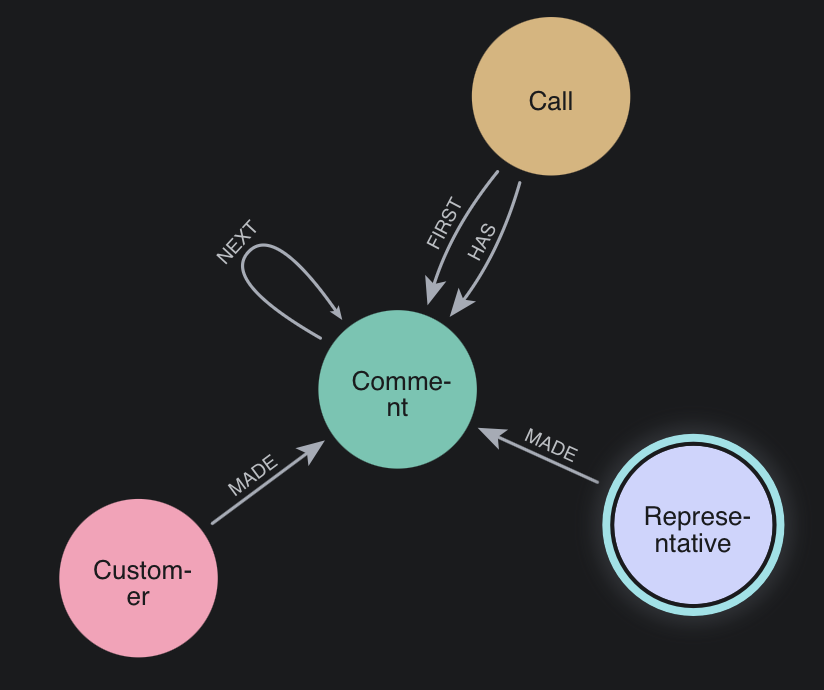